In [290]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams['font.family'] = 'IBM Plex Sans'
import seaborn as sns
sns.set(font="IBM Plex Sans")
plt.style.use('seaborn-colorblind')

In [291]:
def position_mapping(x):
    if 'C' in x:
        return 'Center'
    elif 'F' in x:
        return 'Forward'
    elif 'G' in x:
        return 'Guard'

In [292]:
data = pd.read_csv('./../../data/player_seasonal_stats_advanced.csv')
data['Position'] = data['Pos'].apply(lambda x: position_mapping(x))
data = data[['Player', 'Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%','OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Position']]
data['Player'] = data['Player'].apply(lambda x: x.replace('*', ''))
print(data.shape[0], 'rows')
data = data.drop_duplicates(subset=['Player'], keep='last').reset_index(drop=True)
print(data.shape[0], 'rows')
data

11526 rows
2337 rows


,Player,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Position
0,Chris Anstey,25,73,1007,15.1,0.512,0.016,0.404,10.3,22.5,...,23.1,0.6,1.3,1.9,0.090,-2.1,-0.1,-2.3,-0.1,Center
1,B.J. Armstrong,32,27,583,10.7,0.510,0.156,0.134,0.4,9.2,...,18.6,0.2,0.2,0.4,0.030,-1.8,-2.0,-3.8,-0.3,Guard
2,Anthony Avent,30,49,377,5.5,0.368,0.000,0.333,6.6,15.6,...,15.8,-0.7,0.2,-0.5,-0.065,-6.9,-0.5,-7.4,-0.5,Forward
3,Toby Bailey,24,46,449,10.8,0.483,0.071,0.464,6.6,11.2,...,18.9,0.2,0.6,0.8,0.088,-3.0,-0.1,-3.1,-0.1,Guard
4,Charles Barkley,36,20,620,19.8,0.534,0.117,0.495,13.1,24.4,...,22.3,1.3,0.6,1.9,0.148,2.6,-0.6,2.0,0.6,Forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,Thaddeus Young,34,54,795,14.1,0.573,0.172,0.131,9.4,14.6,...,13.5,0.7,1.1,1.8,0.109,-1.8,1.9,0.1,0.4,Forward
2333,Trae Young,24,73,2541,22.0,0.573,0.331,0.460,2.4,7.0,...,32.6,5.3,1.4,6.7,0.126,5.3,-2.0,3.3,3.4,Guard
2334,Omer Yurtseven,24,9,83,16.7,0.675,0.259,0.222,10.9,21.9,...,18.0,0.2,0.1,0.3,0.159,-2.5,-1.5,-3.9,0.0,Center
2335,Cody Zeller,30,15,217,16.4,0.659,0.034,0.593,13.0,21.8,...,18.1,0.4,0.3,0.7,0.147,-2.0,-0.7,-2.8,0.0,Center


In [293]:
players_with_shoes = pd.read_csv('./../../data/player-shoes-data.csv')
df_train = data[~data['Player'].isin(players_with_shoes['Player'])]
df_test = data[data['Player'].isin(players_with_shoes['Player'])]

# fill nan values
for col in df_train.columns[1:-1]:
    df_train.loc[:,col] = df_train.loc[:,col].fillna(df_train[col].median())
    df_test.loc[:,col] = df_test.loc[:,col].fillna(df_test[col].median())
    
# split into training and test, x and y
X_train = df_train.iloc[:,1:-1].values
y_train = df_train.iloc[:,-1].values
X_test = df_test.iloc[:,1:-1].values
y_test = df_test.iloc[:,-1].values

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1971, 23) (366, 23) (1971,) (366,)


## EDA

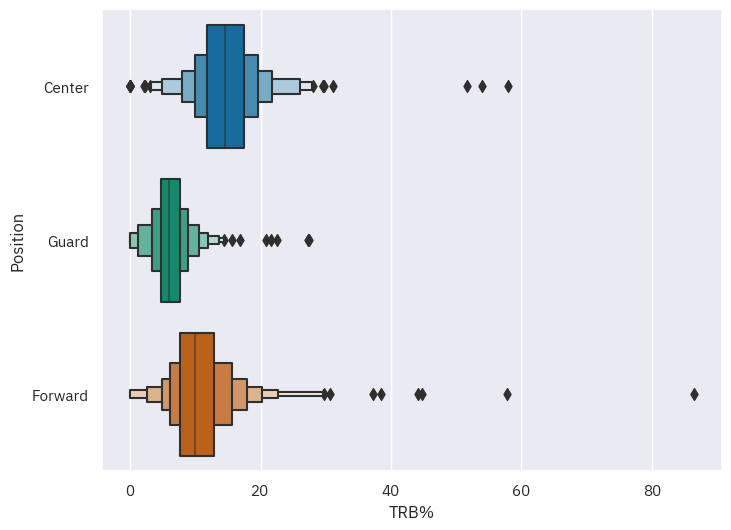

In [294]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxenplot(data=data, x='TRB%', y='Position')
fig.savefig('./../../figures/trb_vs_position.png')

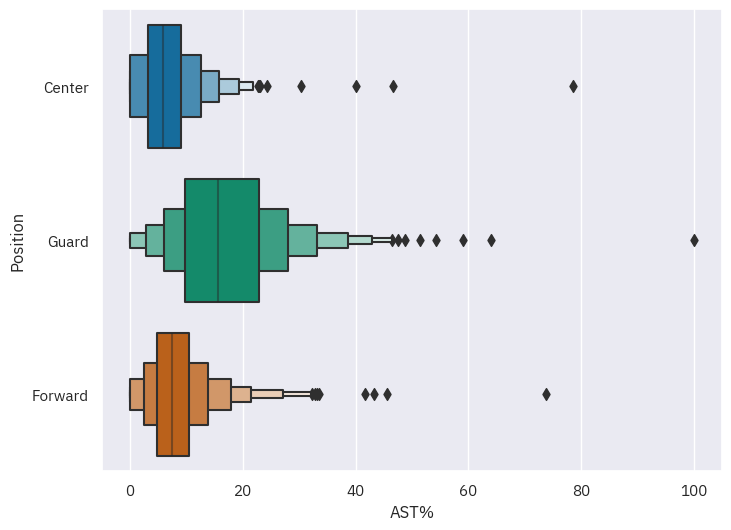

In [295]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxenplot(data=data, x='AST%', y='Position')
fig.savefig('./../../figures/ast_vs_position.png')

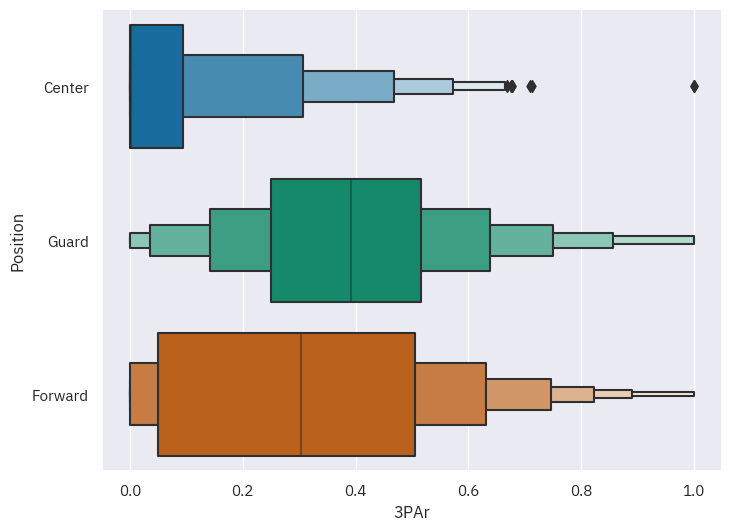

In [296]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxenplot(data=data, x='3PAr', y='Position')
fig.savefig('./../../figures/3par_vs_position.png')

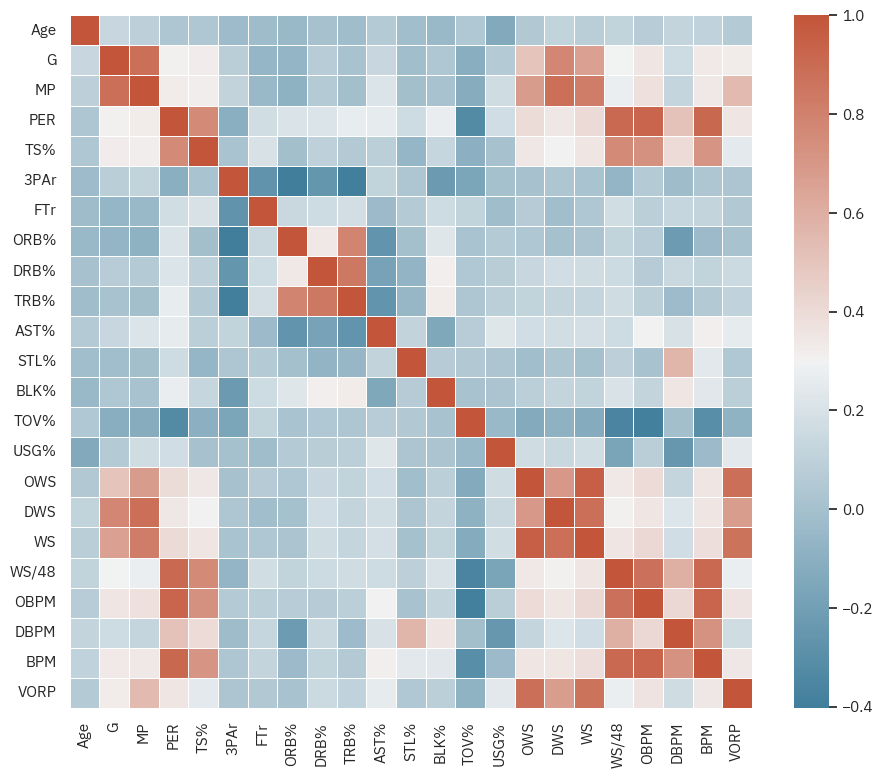

In [297]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data.iloc[:,1:-1].corr(), cmap=cmap, linewidths=.5)

f.savefig('./../../figures/correlation-matrix.png')

### K-Nearest Neighbors

In [298]:
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)

# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 28}
0.6864610572732401


In [299]:
knn = KNeighborsClassifier(n_neighbors=28)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=list(data['Position'].unique())))


0.76775956284153
              precision    recall  f1-score   support

      Center       0.82      0.82      0.82        74
       Guard       0.75      0.63      0.69       145
     Forward       0.76      0.87      0.81       147

    accuracy                           0.77       366
   macro avg       0.78      0.78      0.77       366
weighted avg       0.77      0.77      0.76       366



### Random Forest

In [300]:
rf=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1)
CV_rf.fit(X_train, y_train)
print(CV_rf.best_params_)
print(CV_rf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
0.7021962346591274


In [301]:
rf = RandomForestClassifier(max_depth=8, criterion='gini', max_features='auto', n_estimators=200, random_state=42)
rf.fit(X_train, y_train)    
y_pred_rf = rf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=list(data['Position'].unique())))

0.7759562841530054
              precision    recall  f1-score   support

      Center       0.88      0.78      0.83        74
       Guard       0.76      0.63      0.69       145
     Forward       0.75      0.91      0.82       147

    accuracy                           0.78       366
   macro avg       0.80      0.78      0.78       366
weighted avg       0.78      0.78      0.77       366



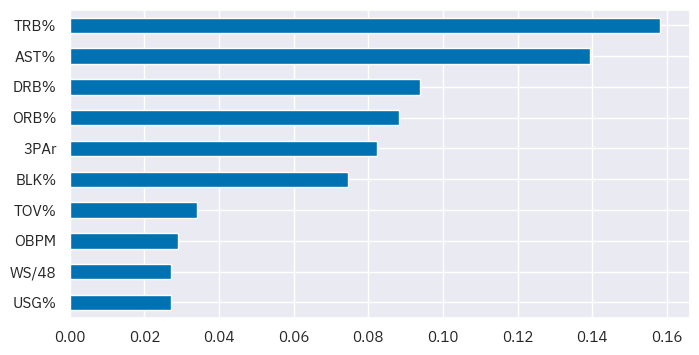

In [302]:
fig, ax = plt.subplots(figsize=(8, 4))
feat_importances = pd.Series(rf.feature_importances_, index=df_train.columns[1:-1])
ax = feat_importances.nlargest(10).iloc[::-1].plot(kind='barh')
fig.savefig('./../../figures/feature_importances.png')

### Decision Tree

In [303]:
dt = DecisionTreeClassifier(random_state=42)
param_grid = { 
    'max_depth' : range(1, 10),
    'criterion' :['gini', 'entropy'],
    'max_features': range(1, X_train.shape[1])
}
CV_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, verbose=1)
CV_dt.fit(X_train, y_train)
best_params = CV_dt.best_params_
best_params['min_samples_leaf'] = 1
best_params['min_samples_split'] = 1
print(best_params)
print(CV_dt.best_score_)

Fitting 5 folds for each of 396 candidates, totalling 1980 fits
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 14, 'min_samples_leaf': 1, 'min_samples_split': 1}
0.6778436034183641


In [304]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=1, min_samples_split=1, max_features=14, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, target_names=list(data['Position'].unique())))

0.7540983606557377
              precision    recall  f1-score   support

      Center       0.79      0.72      0.75        74
       Guard       0.73      0.62      0.67       145
     Forward       0.76      0.90      0.82       147

    accuracy                           0.75       366
   macro avg       0.76      0.75      0.75       366
weighted avg       0.75      0.75      0.75       366



### Logistic Regression

In [305]:
clf = LogisticRegression(random_state=42, multi_class='multinomial')
param_grid = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
CV_lr = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=1)
CV_lr.fit(X_train, y_train)
print(CV_lr.best_params_)
print(CV_lr.best_score_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.7047278802287477


In [306]:
clf = LogisticRegression(random_state=42, multi_class='multinomial', solver='newton-cg', penalty='l2', C=100)
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)
print(accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=list(data['Position'].unique())))

0.7513661202185792
              precision    recall  f1-score   support

      Center       0.83      0.81      0.82        74
       Guard       0.72      0.63      0.67       145
     Forward       0.74      0.84      0.79       147

    accuracy                           0.75       366
   macro avg       0.76      0.76      0.76       366
weighted avg       0.75      0.75      0.75       366



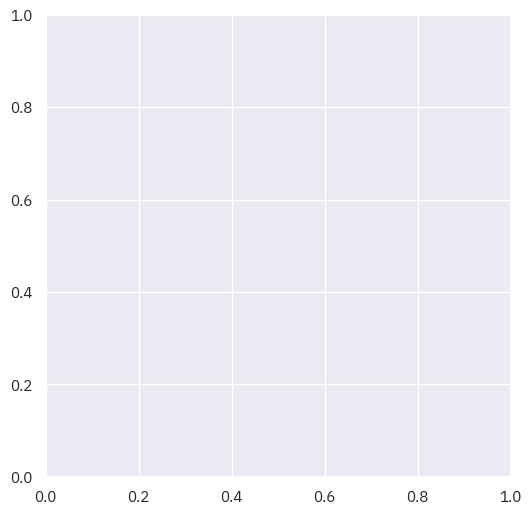

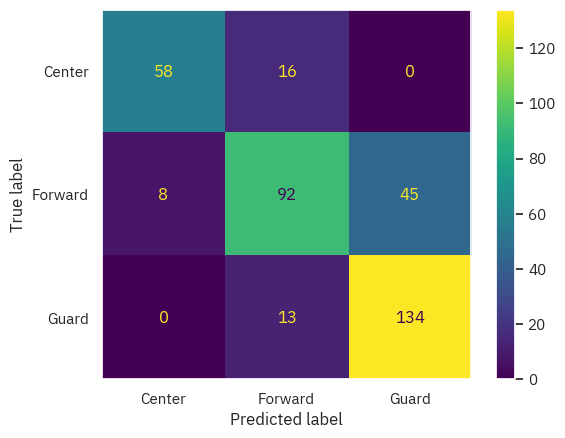

In [309]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(6,6));
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=rf.classes_).plot();
plt.grid(False)
cm.figure_.savefig('./../../figures/confusion_matrix_rf.png')

In [308]:
proba = rf.predict_proba(X_test)
inspect_proba = df_test[np.max(proba, axis=1) <= 0.45].reset_index(drop=True)
inspect_proba = pd.concat([inspect_proba, pd.DataFrame(proba[np.max(proba, axis=1) <= 0.45], columns=[x + ' Proba' for x in rf.classes_])], axis=1)
inspect_proba.style.format(precision=2).background_gradient(subset=['Center Proba', 'Forward Proba', 'Guard Proba'], axis=1)

,Player,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Position,Center Proba,Forward Proba,Guard Proba
0,Michael Jordan,39,82,3031,19.30,0.49,0.04,0.21,2.80,16.70,9.70,21.10,2.20,1.00,9.40,28.70,2.90,3.40,6.20,0.10,1.80,0.00,1.70,2.80,Forward,0.14,0.44,0.42
1,Paul Pierce,39,25,277,5.70,0.54,0.61,0.19,0.40,18.50,9.70,5.00,0.70,1.50,17.40,14.80,-0.20,0.30,0.10,0.01,-4.70,0.10,-4.70,-0.20,Forward,0.14,0.42,0.44
2,Khem Birch,30,20,162,9.40,0.63,0.06,0.16,5.20,12.80,8.70,5.80,1.50,3.00,19.00,11.10,0.10,0.20,0.20,0.07,-4.60,1.10,-3.50,-0.10,Center,0.40,0.37,0.23
3,Jimmy Butler,33,64,2138,27.60,0.65,0.12,0.62,7.50,13.30,10.30,27.10,2.70,1.00,8.20,25.60,9.40,2.90,12.30,0.28,6.70,2.00,8.70,5.80,Forward,0.22,0.43,0.35
4,Gorgui Dieng,33,31,358,9.90,0.49,0.64,0.11,7.90,25.40,16.30,19.40,0.50,3.20,20.70,17.90,-0.20,0.20,0.00,0.00,-4.00,0.10,-3.90,-0.20,Center,0.26,0.43,0.31
5,Kevin Durant,34,47,1672,25.90,0.68,0.27,0.39,1.20,19.50,10.50,24.50,1.00,3.40,13.40,30.70,4.70,2.10,6.80,0.19,6.00,1.20,7.10,3.90,Forward,0.36,0.39,0.25
6,Udonis Haslem,42,7,71,6.20,0.43,0.31,0.17,6.40,12.00,9.10,0.00,0.70,2.90,3.10,20.10,-0.10,0.10,0.00,-0.01,-8.20,-3.90,-12.10,-0.20,Center,0.26,0.39,0.35
7,Maxi Kleber,31,37,930,8.70,0.59,0.66,0.23,3.70,13.30,8.40,7.50,0.60,2.90,12.70,10.30,0.70,0.60,1.30,0.07,-2.20,0.00,-2.20,0.00,Forward,0.19,0.38,0.43
8,Cody Martin,27,7,134,8.70,0.45,0.39,0.19,6.20,13.00,9.50,11.00,1.40,0.60,4.90,12.90,0.00,0.10,0.10,0.04,-3.80,-0.80,-4.60,-0.10,Forward,0.12,0.45,0.43
9,Ben Simmons,26,42,1105,13.40,0.56,0.01,0.24,4.20,22.20,13.40,31.30,2.40,1.90,27.20,14.30,0.50,1.70,2.20,0.10,-2.20,2.60,0.40,0.70,Guard,0.32,0.34,0.33
